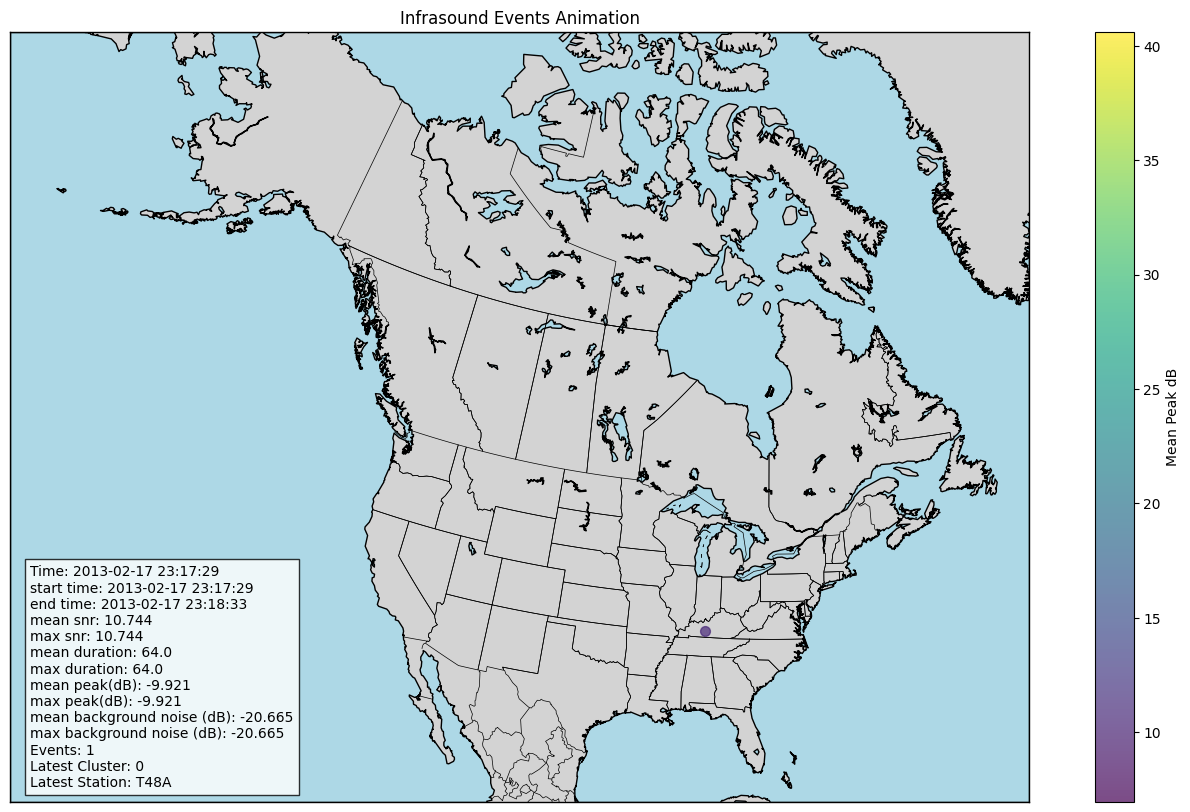

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import Normalize
from mpl_toolkits.basemap import Basemap

# Read the CSV file
station_cluster_data = pd.read_csv('data/result.csv')
station_location_data = pd.read_csv('data/iris-station-list.csv')
df = station_cluster_data.merge(station_location_data, how= 'left')
df.to_csv('data/result2.csv')

# Convert start_time to datetime
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])

# Sort the dataframe by start_time
df = df.sort_values('start_time')

# Set up the plot
fig, ax = plt.subplots(figsize=(15, 10))

# Create a Basemap instance
m = Basemap(
    projection='lcc', 
    resolution='l', 
    lat_0=25, lon_0=-80,
    llcrnrlon=-145, llcrnrlat=7, urcrnrlon=-30, urcrnrlat=75
)

# Draw map features
m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.fillcontinents(color='lightgray', lake_color='lightblue')
m.drawmapboundary(fill_color='lightblue')

# Convert lat/lon to map coordinates
x, y = m(df['longitude'].values, df['latitude'].values)

# Normalize mean_peak_dB for color mapping
norm = Normalize(vmin=df['mean_snr_db'].min(), vmax=df['mean_snr_db'].max())

# Create a scatter plot
scat = m.scatter(x, y, c=df['mean_snr_db'], cmap='viridis', norm=norm, s=50, alpha=0.7)

# Add a colorbar
cbar = plt.colorbar(scat)
cbar.set_label('Mean Peak dB')

# Add title and labels
plt.title('Infrasound Events Animation')
ax.text(0.02, 0.02, '', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.8))

# Animation update function
def update(frame):
    current_time = df['start_time'].iloc[frame]
    visible = (df['start_time'] <= current_time) & (df['end_time'] > current_time)
    
    scat.set_offsets(list(zip(x[visible], y[visible])))
    scat.set_array(df['mean_snr_db'][visible])
    
    info_text = (
        f"Time: {current_time}\n"
        f"start time: {df['start_time'][visible].iloc[-1]}\n"
        f"end time: {pd.to_datetime(df['end_time'][visible].iloc[-1])}\n"
        f"mean snr: {df['mean_snr_db'][visible].iloc[-1]}\n"
        f"max snr: {df['max_snr_db'][visible].iloc[-1]}\n"
        f"mean duration: {df['mean_duration_sec'][visible].iloc[-1]}\n"
        f"max duration: {df['max_duration_sec'][visible].iloc[-1]}\n"
        f"mean peak(dB): {df['max_peak_db'][visible].iloc[-1]}\n"
        f"max peak(dB): {df['mean_peak_db'][visible].iloc[-1]}\n"
        f"mean background noise (dB): {df['mean_background_db'][visible].iloc[-1]}\n"
        f"max background noise (dB): {df['max_background_db'][visible].iloc[-1]}\n"
        f"Events: {visible.sum()}\n"
        f"Latest Cluster: {df['cluster'][visible].iloc[-1]}\n"
        f"Latest Station: {df['station'][visible].iloc[-1]}"
    )
    ax.texts[-1].set_text(info_text)
    return scat,

fig.set_size_inches(17, 10)

# Create the animation
anim = animation.FuncAnimation(fig, update, frames=len(df), interval=100, blit=False)
writervideo = animation.FFMpegWriter(fps=5) 
anim.save("animation2.mp4", writer=writervideo, dpi=300)

plt.show()